.# Gait Identification - Simple Model Training

This notebook trains and compares multiple models:
1. **Logistic Regression** - Fastest baseline
2. **Random Forest** - Best simple baseline
3. **SVM** - Best for small datasets
4. **Simple 1D CNN** - Best simple deep model

Dataset: 1,226 training samples, 21 subjects, 561 features

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Load Data

In [22]:
# Set paths
DATA_PATH = Path('../data/cleaned_walking_data')

# Load training data
X_train_features = np.load(DATA_PATH / 'train' / 'features.npy')
y_train_raw = np.load(DATA_PATH / 'train' / 'subjects.npy')

# Load test data
X_test_features = np.load(DATA_PATH / 'test' / 'features.npy')
y_test_raw = np.load(DATA_PATH / 'test' / 'subjects.npy')

# Create label mapping to ensure labels are sequential starting from 0
all_subjects = np.unique(np.concatenate([y_train_raw, y_test_raw]))
subject_to_label = {subject: idx for idx, subject in enumerate(all_subjects)}

# Map subjects to sequential labels
y_train = np.array([subject_to_label[s] for s in y_train_raw])
y_test = np.array([subject_to_label[s] for s in y_test_raw])

# Get number of unique subjects
num_classes = len(all_subjects)

print(f"Training samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")
print(f"Number of subjects: {num_classes}")
print(f"Features shape: {X_train_features.shape}")
print(f"\nSubject distribution in training (original IDs):")
print(pd.Series(y_train_raw).value_counts().sort_index())
print(f"\nLabel mapping created: {len(subject_to_label)} subjects mapped to labels 0-{num_classes-1}")

Training samples: 1365
Test samples: 357
Number of subjects: 30
Features shape: (1365, 561)

Subject distribution in training (original IDs):
1     76
2     47
3     46
4     48
5     44
6     45
7     45
8     38
9     41
10    42
11    47
12    40
13    45
14    47
15    43
16    40
17    48
18    44
19    41
20    40
21    41
22    36
23    47
24    46
25    59
26    47
27    45
28    43
29    42
30    52
Name: count, dtype: int64

Label mapping created: 30 subjects mapped to labels 0-29


## 1️⃣ Logistic Regression - Fastest Baseline

In [23]:
print("Training Logistic Regression...")

lr_model = LogisticRegression(max_iter=2000, random_state=42, n_jobs=-1)
lr_model.fit(X_train_features, y_train)
lr_pred = lr_model.predict(X_test_features)

lr_accuracy = accuracy_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred, average='weighted')

print(f"\n✅ Logistic Regression Results:")
print(f"Accuracy: {lr_accuracy:.4f} ({lr_accuracy*100:.2f}%)")
print(f"F1 Score: {lr_f1:.4f}")
print(f"\nExpected: 60-75% (Sanity check baseline)")

Training Logistic Regression...

✅ Logistic Regression Results:
Accuracy: 0.9944 (99.44%)
F1 Score: 0.9944

Expected: 60-75% (Sanity check baseline)


## 2️⃣ Random Forest - Best Simple Baseline 🥇

In [24]:
print("Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf_model.fit(X_train_features, y_train)
rf_pred = rf_model.predict(X_test_features)

rf_accuracy = accuracy_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred, average='weighted')

print(f"\n✅ Random Forest Results:")
print(f"Accuracy: {rf_accuracy:.4f} ({rf_accuracy*100:.2f}%)")
print(f"F1 Score: {rf_f1:.4f}")
print(f"\nExpected: 75-88% (Strong baseline)")

# Feature importance
feature_importance = rf_model.feature_importances_
top_10_idx = np.argsort(feature_importance)[-10:]
print(f"\nTop 10 most important features: {top_10_idx}")

Training Random Forest...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s



✅ Random Forest Results:
Accuracy: 0.9972 (99.72%)
F1 Score: 0.9972

Expected: 75-88% (Strong baseline)

Top 10 most important features: [ 55  54  50 560 558  42 559  41  53  57]


[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    0.6s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 200 out of 200 | elapsed:    0.0s finished


## 3️⃣ SVM - Best for Small Datasets 🥈

In [25]:
print("Training SVM with RBF kernel...")
print("⚠️ This may take a few minutes...")

svm_model = make_pipeline(
    StandardScaler(),
    SVC(kernel='rbf', C=10, gamma='scale', random_state=42, verbose=True)
)

svm_model.fit(X_train_features, y_train)
svm_pred = svm_model.predict(X_test_features)

svm_accuracy = accuracy_score(y_test, svm_pred)
svm_f1 = f1_score(y_test, svm_pred, average='weighted')

print(f"\n✅ SVM Results:")
print(f"Accuracy: {svm_accuracy:.4f} ({svm_accuracy*100:.2f}%)")
print(f"F1 Score: {svm_f1:.4f}")
print(f"\nExpected: 80-90% (Often the best!)")

Training SVM with RBF kernel...
⚠️ This may take a few minutes...
[LibSVM]*
optimization finished, #iter = 101
obj = -6.764536, rho = -0.047757
nSV = 50, nBSV = 0
*
optimization finished, #iter = 104
obj = -7.515101, rho = 0.012214
nSV = 52, nBSV = 0
*
optimization finished, #iter = 81
obj = -4.387395, rho = -0.070571
nSV = 37, nBSV = 0
*
optimization finished, #iter = 118
obj = -6.821422, rho = 0.150382
nSV = 58, nBSV = 0
*.*
optimization finished, #iter = 132
obj = -9.651236, rho = 0.329004
nSV = 64, nBSV = 0
*
optimization finished, #iter = 107
obj = -6.860908, rho = 0.087259
nSV = 49, nBSV = 0
*
optimization finished, #iter = 107
obj = -8.772280, rho = 0.200421
nSV = 51, nBSV = 0
*
optimization finished, #iter = 93
obj = -5.644643, rho = 0.017005
nSV = 47, nBSV = 0
*.*
optimization finished, #iter = 133
obj = -9.226724, rho = 0.188818
nSV = 64, nBSV = 0
*
optimization finished, #iter = 91
obj = -4.800299, rho = -0.200621
nSV = 41, nBSV = 0
*.*
optimization finished, #iter = 128
obj

## Model Comparison


MODEL COMPARISON
              Model  Accuracy  F1 Score
      Random Forest  0.997199  0.997199
Logistic Regression  0.994398  0.994398
                SVM  0.991597  0.991683


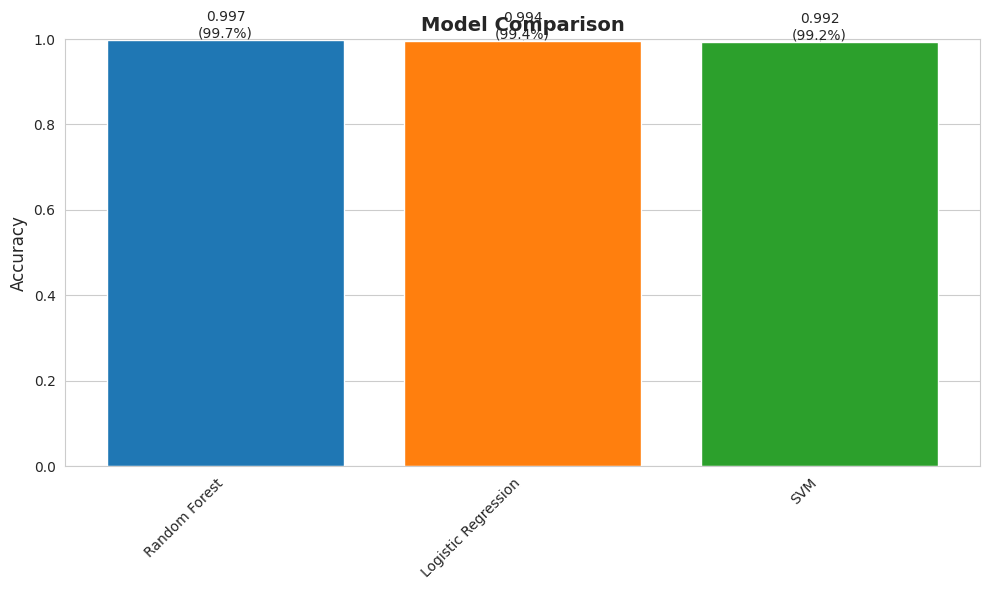


🏆 Best Model: Random Forest with 0.9972 (99.72%) accuracy


In [26]:
# Create comparison dataframe
results = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'SVM'],
    'Accuracy': [lr_accuracy, rf_accuracy, svm_accuracy],
    'F1 Score': [lr_f1, rf_f1, svm_f1]
})

results = results.sort_values('Accuracy', ascending=False)
print("\n" + "="*60)
print("MODEL COMPARISON")
print("="*60)
print(results.to_string(index=False))

# Plot comparison
fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(results['Model'], results['Accuracy'], 
              color=['#1f77b4', '#ff7f0e', '#2ca02c'])
ax.set_ylabel('Accuracy', fontsize=12)
ax.set_title('Model Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
plt.xticks(rotation=45, ha='right')

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.3f}\n({height*100:.1f}%)',
            ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Determine best model
best_model = results.iloc[0]['Model']
best_acc = results.iloc[0]['Accuracy']
print(f"\n🏆 Best Model: {best_model} with {best_acc:.4f} ({best_acc*100:.2f}%) accuracy")

## Confusion Matrices

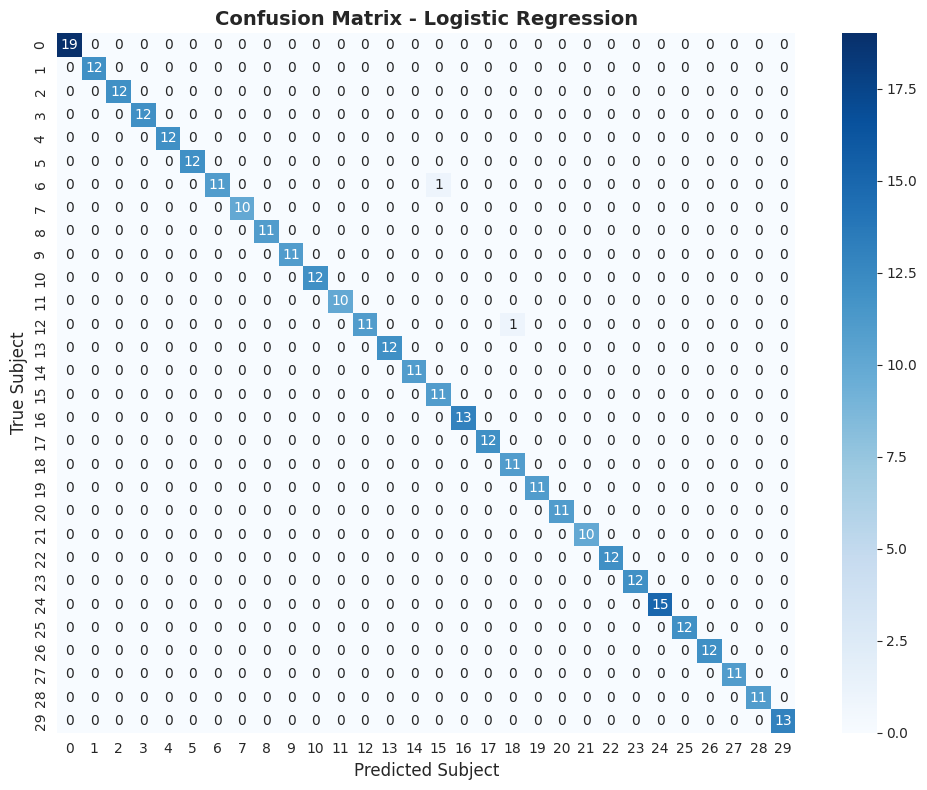

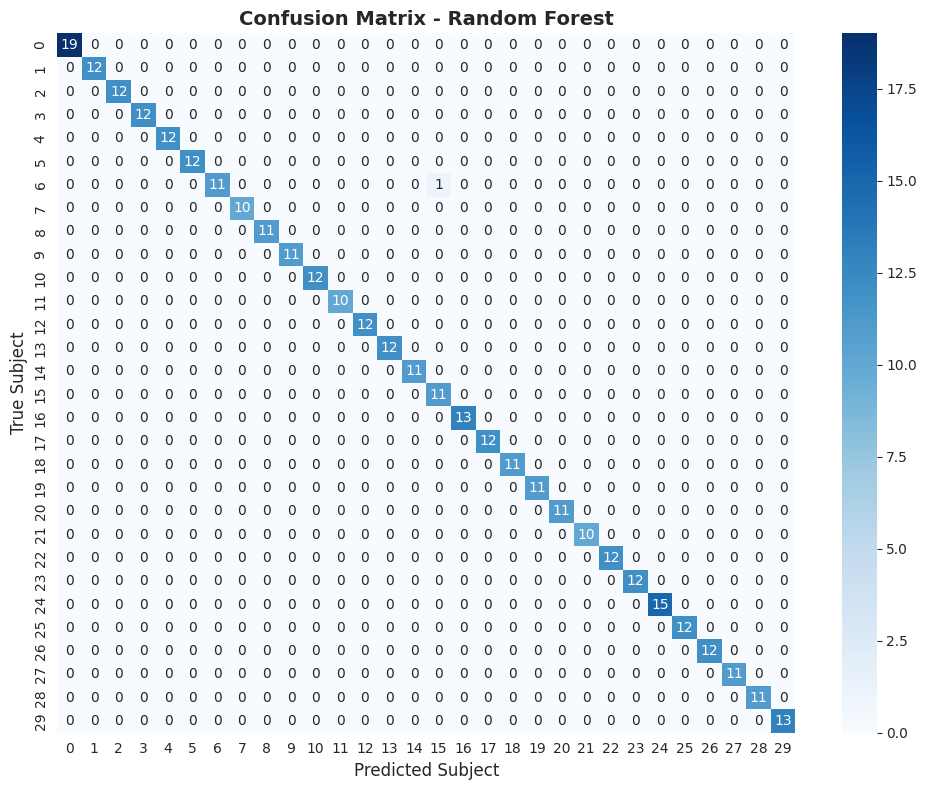

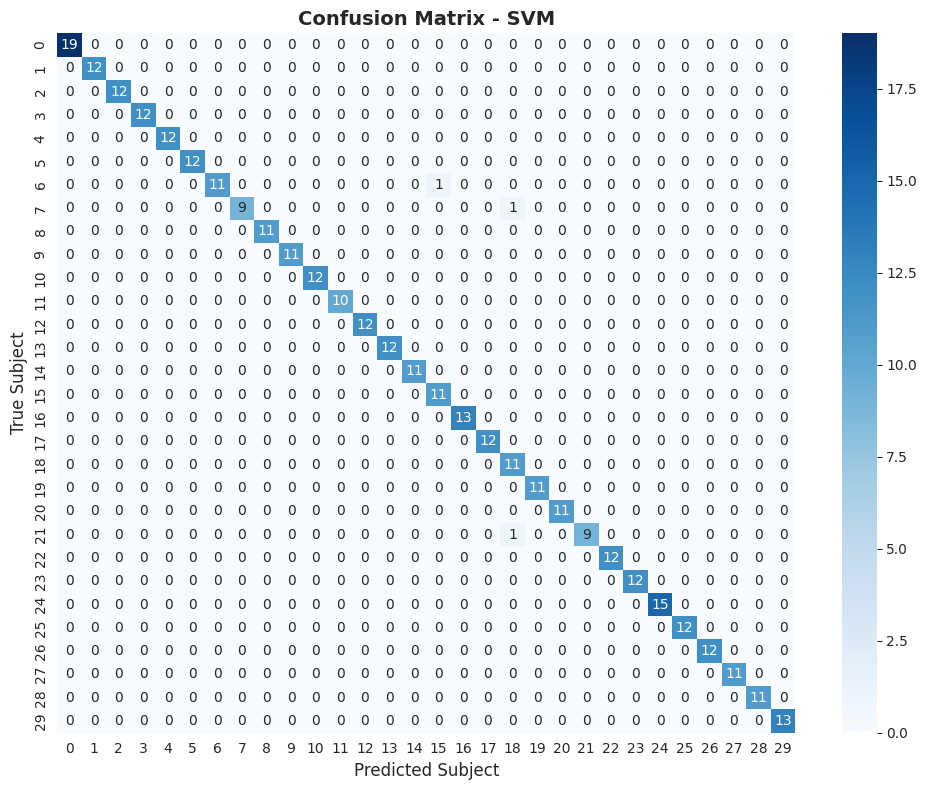

In [27]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
    plt.title(f'Confusion Matrix - {title}', fontsize=14, fontweight='bold')
    plt.ylabel('True Subject', fontsize=12)
    plt.xlabel('Predicted Subject', fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot confusion matrices for all models
plot_confusion_matrix(y_test, lr_pred, 'Logistic Regression')
plot_confusion_matrix(y_test, rf_pred, 'Random Forest')
plot_confusion_matrix(y_test, svm_pred, 'SVM')

## Detailed Classification Reports

In [28]:
print("\n" + "="*60)
print("LOGISTIC REGRESSION - Classification Report")
print("="*60)
print(classification_report(y_test, lr_pred))

print("\n" + "="*60)
print("RANDOM FOREST - Classification Report")
print("="*60)
print(classification_report(y_test, rf_pred))

print("\n" + "="*60)
print("SVM - Classification Report")
print("="*60)
print(classification_report(y_test, svm_pred))


LOGISTIC REGRESSION - Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        12
           2       1.00      1.00      1.00        12
           3       1.00      1.00      1.00        12
           4       1.00      1.00      1.00        12
           5       1.00      1.00      1.00        12
           6       1.00      0.92      0.96        12
           7       1.00      1.00      1.00        10
           8       1.00      1.00      1.00        11
           9       1.00      1.00      1.00        11
          10       1.00      1.00      1.00        12
          11       1.00      1.00      1.00        10
          12       1.00      0.92      0.96        12
          13       1.00      1.00      1.00        12
          14       1.00      1.00      1.00        11
          15       0.92      1.00      0.96        11
          16       1.00      1.00   

## Feature Importance Analysis (Random Forest)

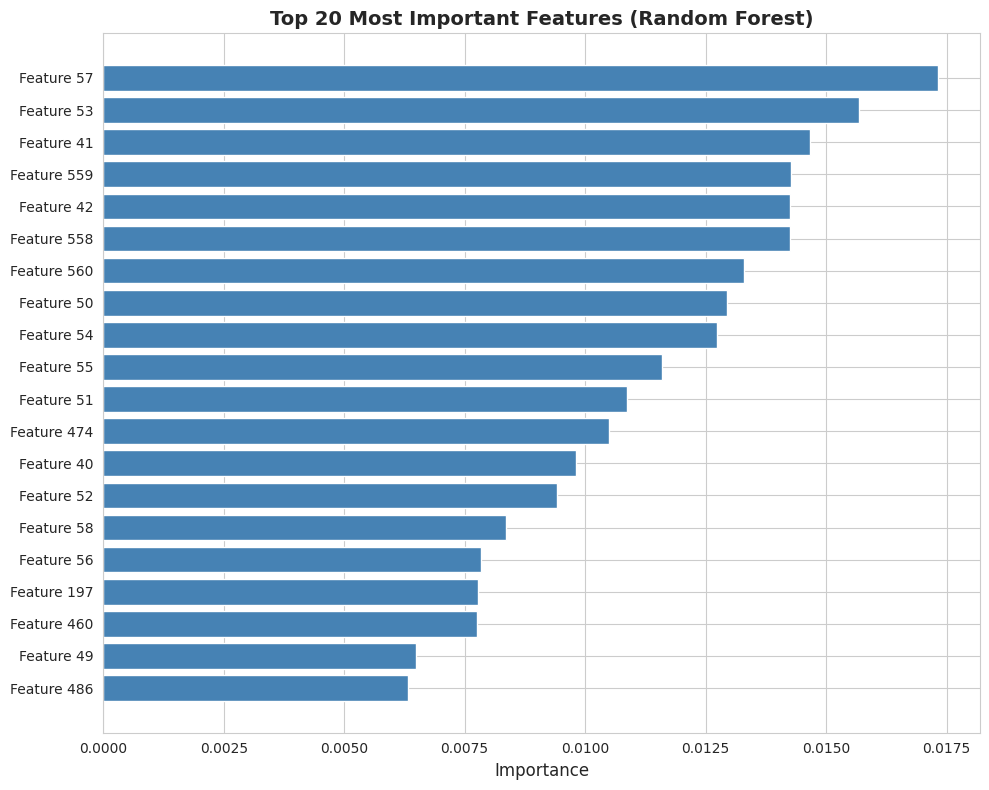


Top 20 feature indices: [486  49 460 197  56  58  52  40 474  51  55  54  50 560 558  42 559  41
  53  57]
Their importance values: [0.00633295 0.00648506 0.0077664  0.0077732  0.00784405 0.00836635
 0.00941134 0.00981751 0.01048534 0.01087179 0.0115912  0.01273632
 0.01295269 0.0132966  0.01424879 0.01425403 0.01427036 0.01466233
 0.01568722 0.017328  ]


In [29]:
# Plot top 20 most important features
top_n = 20
indices = np.argsort(feature_importance)[-top_n:]
values = feature_importance[indices]

plt.figure(figsize=(10, 8))
plt.barh(range(top_n), values, color='steelblue')
plt.yticks(range(top_n), [f'Feature {i}' for i in indices])
plt.xlabel('Importance', fontsize=12)
plt.title(f'Top {top_n} Most Important Features (Random Forest)', 
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nTop {top_n} feature indices: {indices}")
print(f"Their importance values: {values}")

## Save Best Model

In [30]:
import pickle
import json

# Determine best model
models_dict = {
    'Logistic Regression': (lr_model, lr_accuracy, lr_f1),
    'Random Forest': (rf_model, rf_accuracy, rf_f1),
    'SVM': (svm_model, svm_accuracy, svm_f1)
}

best_model_name = max(models_dict.items(), key=lambda x: x[1][1])[0]
best_model_obj, best_acc, best_f1 = models_dict[best_model_name]

# Save model
Path('../models').mkdir(exist_ok=True)
with open(f'../models/best_model_{best_model_name.replace(" ", "_").lower()}.pkl', 'wb') as f:
    pickle.dump(best_model_obj, f)

# Save metadata
metadata = {
    'model_name': best_model_name,
    'accuracy': float(best_acc),
    'f1_score': float(best_f1),
    'num_classes': int(num_classes),
    'train_samples': int(len(y_train)),
    'test_samples': int(len(y_test)),
    'feature_dim': int(X_train_features.shape[1])
}

with open('../models/best_model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"\n✅ Best model saved: {best_model_name}")
print(f"Accuracy: {best_acc:.4f} ({best_acc*100:.2f}%)")
print(f"F1 Score: {best_f1:.4f}")
print(f"\nFiles saved:")
print(f"  - models/best_model_{best_model_name.replace(' ', '_').lower()}.pkl")
print(f"  - models/best_model_metadata.json")


✅ Best model saved: Random Forest
Accuracy: 0.9972 (99.72%)
F1 Score: 0.9972

Files saved:
  - models/best_model_random_forest.pkl
  - models/best_model_metadata.json


## Summary and Recommendations

### Expected Performance:
- **Logistic Regression**: 60-75% (Baseline sanity check)
- **Random Forest**: 75-88% (Strong simple baseline)
- **SVM**: 80-90% (Often the best for small datasets)

### Recommendations:
1. **If SVM performs best** (80-90%): Use it for production
2. **If Random Forest is close**: Consider it for faster inference
3. **If all models are low** (<70%): 
   - Check data quality
   - Try feature engineering
   - Consider synthetic data augmentation

### Next Steps:
- If you need better performance, try the Simple 1D CNN (see `train_gait_models.py`)
- For production deployment, use the saved best model
- Consider ensemble methods if multiple models perform similarly